## This script performs ADF and KPSS Stationarity tests on the average temperature and food prices time series per country

In [11]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from pandas import read_csv
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

Plot and print results of ADF and KPSS

In [12]:
def st_check(df, country, col, path, output, type):
    X = df[col]
    timeseries = X

    rolmean = timeseries.rolling(12).mean() ## as month is year divide by 12
    rolstd = timeseries.rolling(12).std()

    #plot rolling statistics:
    plt.figure(figsize=(16,12))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Std Deviation -' + country)

    #ADF test
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    print("=" * 70, file=output)
    print(country, file=output)
    print("="*70, file=output)
    print ('Dickey-Fuller Test for ' +col , file=output)
    print (dfoutput, file=output)
    print('Critical Values:', file=output)
    for key, value in dftest[4].items():
         print('\t%s: %.3f' % (key, value), file=output)
         dfoutput['Critical Value (%s)'%key] = value

    adf_check = 0
    if dfoutput['Test Statistic'] > dfoutput['Critical Value (1%)']:
        #accept null hypothesis (series has a unit root)
        print('p-value = ' + str(dftest[1])+ '\nTest Stat > Critical Value (1%) then Accept H0: The series ' + timeseries.name + ' is likely non-stationary', file=output)
        adf_check = 1
    else:
        #reject null hypothesis (series has no unit root - series is stationary)
        print('p-value = ' + str(dftest[1]) + '\nTest Stat <= Critical Value (1%) then Reject H0: The series ' + timeseries.name + ' is likely stationary', file=output)
    print("="*70, file=output)

    plt.figtext(.3,.15,str(dfoutput))
    plt.savefig(path + country + '.png')

    #kpss test
    kpss_check = 0
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
       kpss_output['Critical Value (%s)'%key] = value
    print ('KPSS Test for ' +col , file=output)
    print(kpss_output, file= output)
    if kpss_output['Test Statistic'] > kpss_output['Critical Value (1%)']:
        #reject the null hypothesis (series has a unit root - non-stationary)
        print('p-value = ' + str(dftest[1])+ '\nTest Stat > Critical Value (1%) then Reject H0: The series ' + timeseries.name + ' is likely non-stationary', file=output)
    else:
        #accept the null hypothesis (has trend stationarity)
        print('p-value = ' + str(dftest[1]) + '\nTest Stat <= Critical Value (1%) then Accept H0: The series ' + timeseries.name + ' is likely stationary', file=output)
        kpss_check = 1

    #check result of both adf and kpss
    if(kpss_check ==  0) and (adf_check == 1):
        # Unit root: accept null; KPSS test: reject null
        print('***Both imply that series has unit root (non-stationary)', file=output)
    elif (kpss_check == 1) and (adf_check == 0):
        #unit root: reject null; KPSS test: accept null
        print('***Both imply that series is stationary', file=output)
    elif (kpss_check == 1) and (adf_check == 1):
        # unit root: reject null; KPSS test: reject null
        print('***ADF - no unit root but KPSS - with a unit root --> need to check further', file=output)
    elif (kpss_check == 0) and (adf_check == 0):
        # unit root: accept null; KPSS test: accept null
        print('***The process is trend-stationary but has a unit root', file=output)

In [13]:
series1 = read_csv('.\Market_food_prices_w_temp_reduced.csv', engine='python')
series1 = series1.sort_values('period')
df = series1.groupby('country')
idx = df.nth(1).index

In [14]:
text_file1 = open(".\Stationary-Test-Univariate-avg-temp.doc", "w")
text_file2 = open(".\Stationary-Test-Univariate-food-prices.doc", "w")

Check stationarity for avg temp

writing ADF test result for avg_temp...


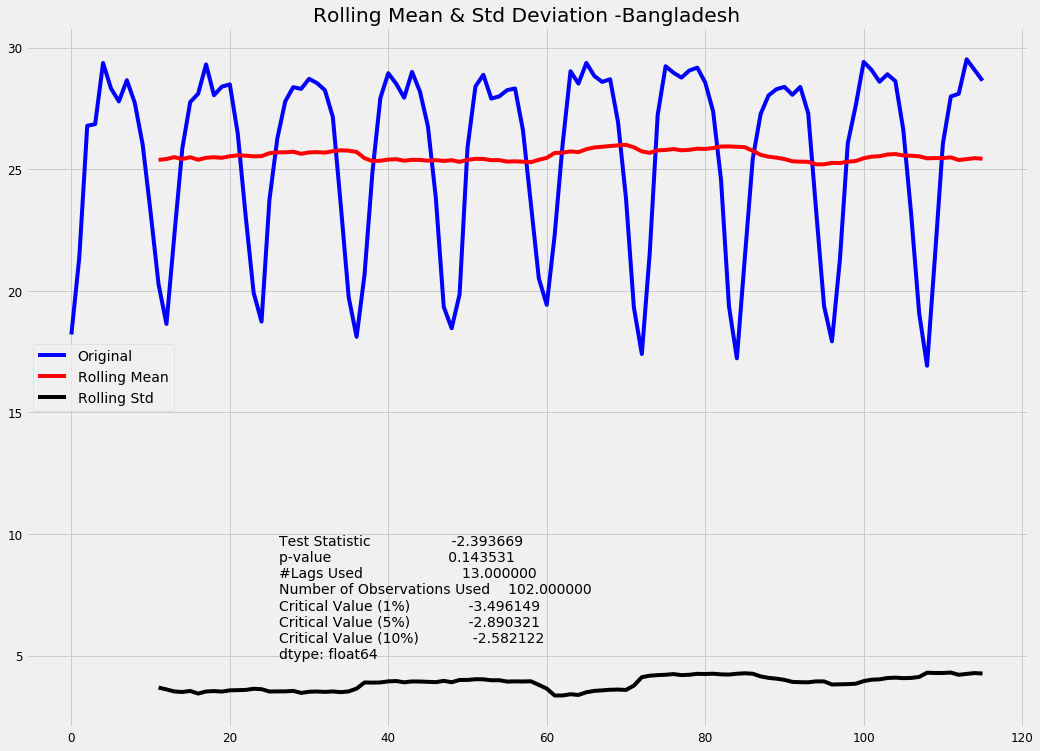

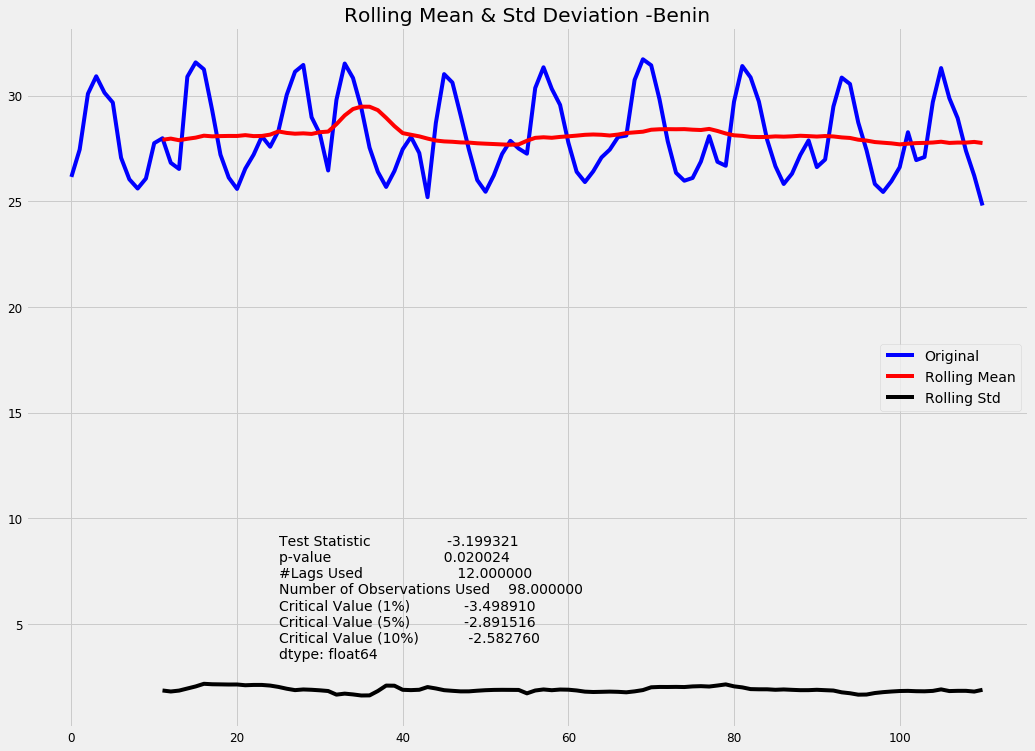

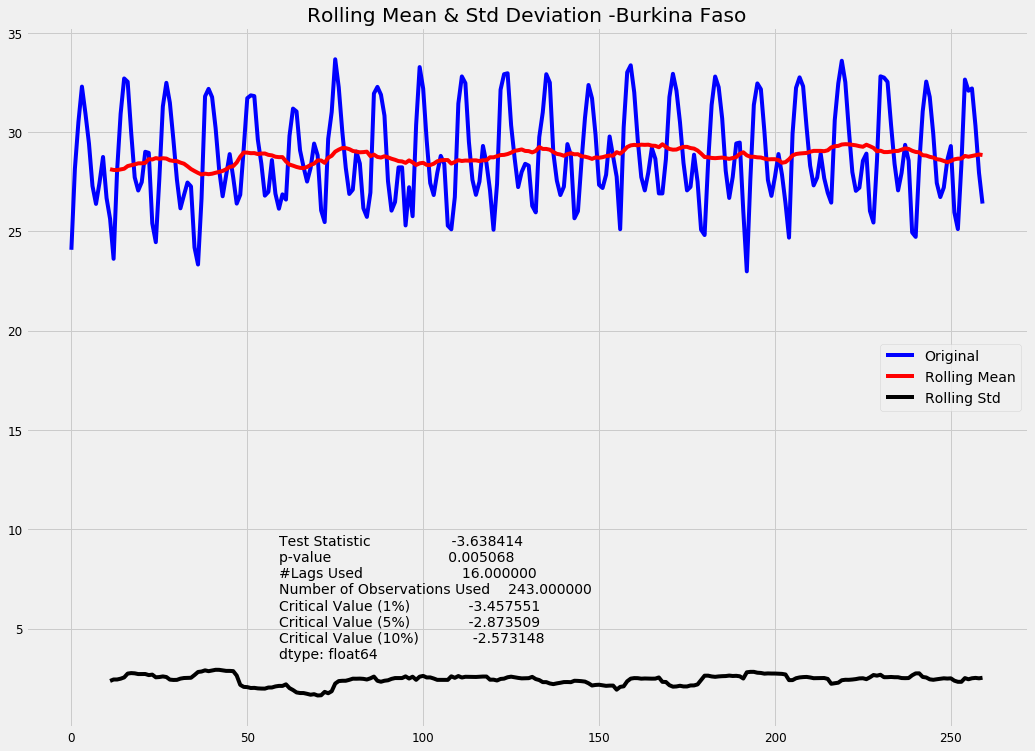

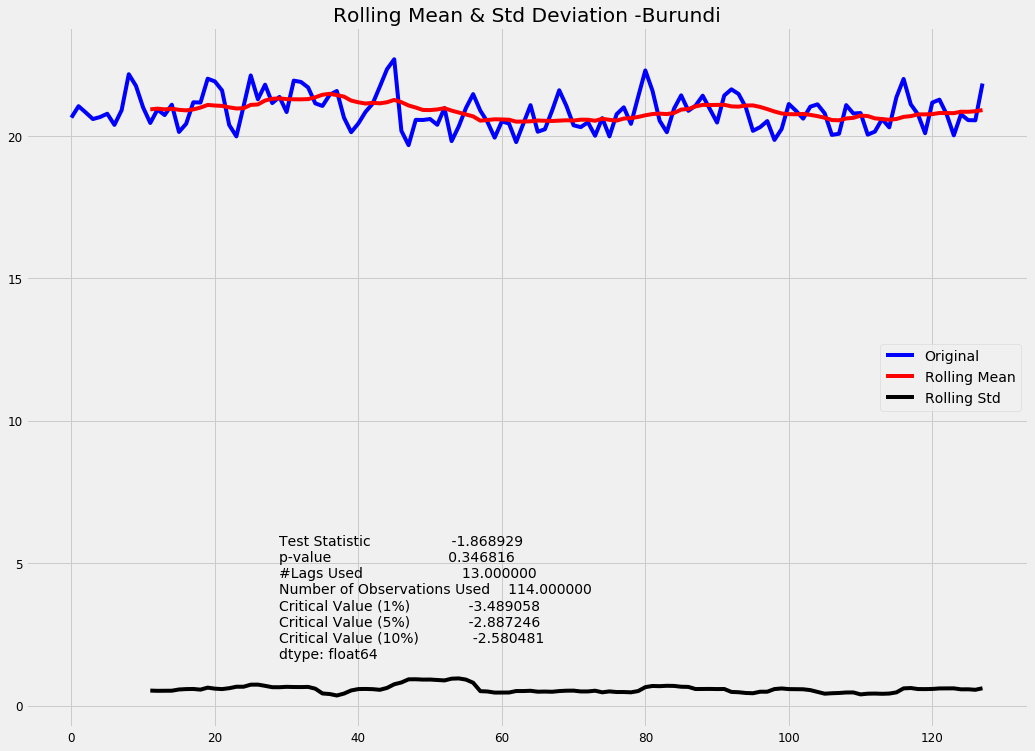

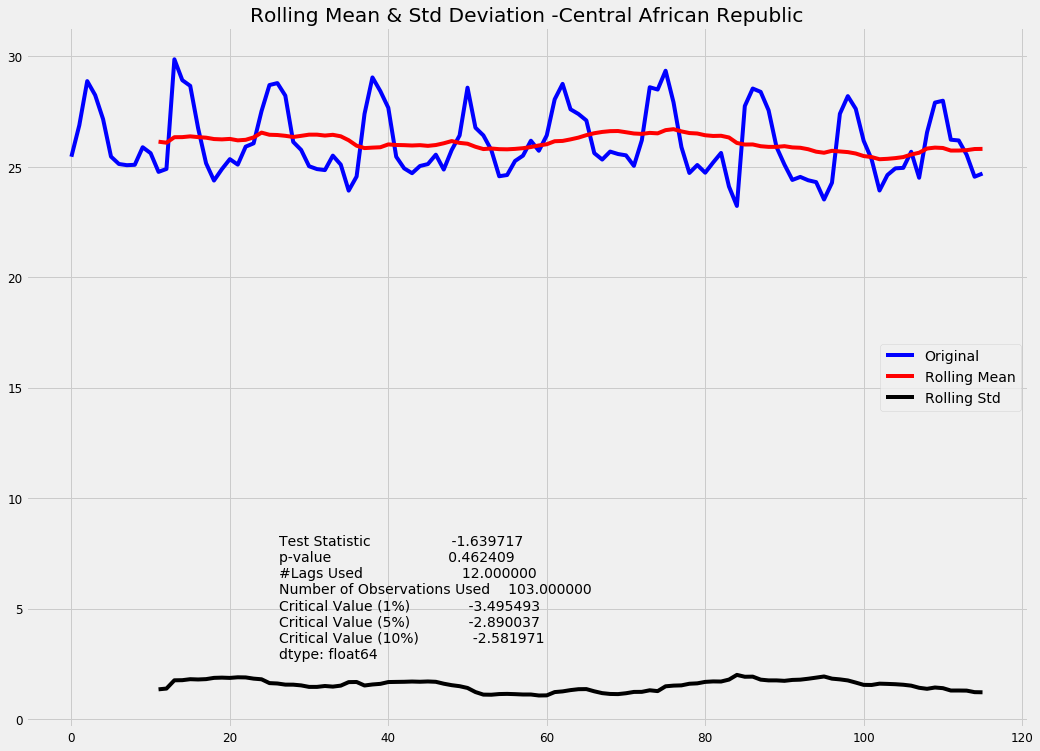

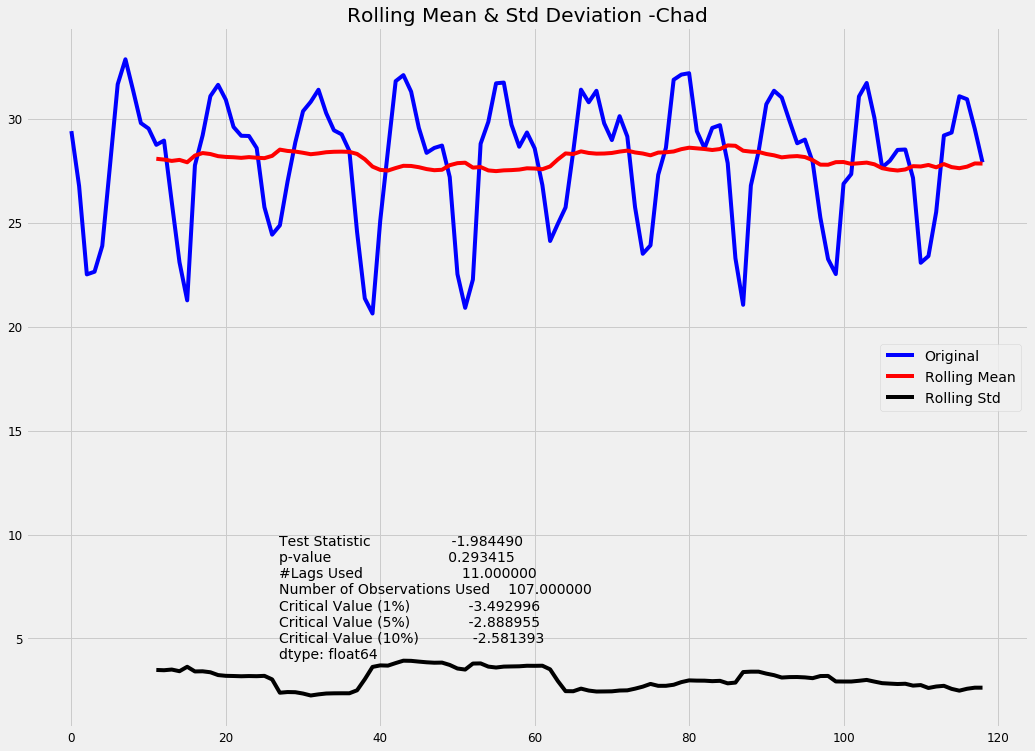

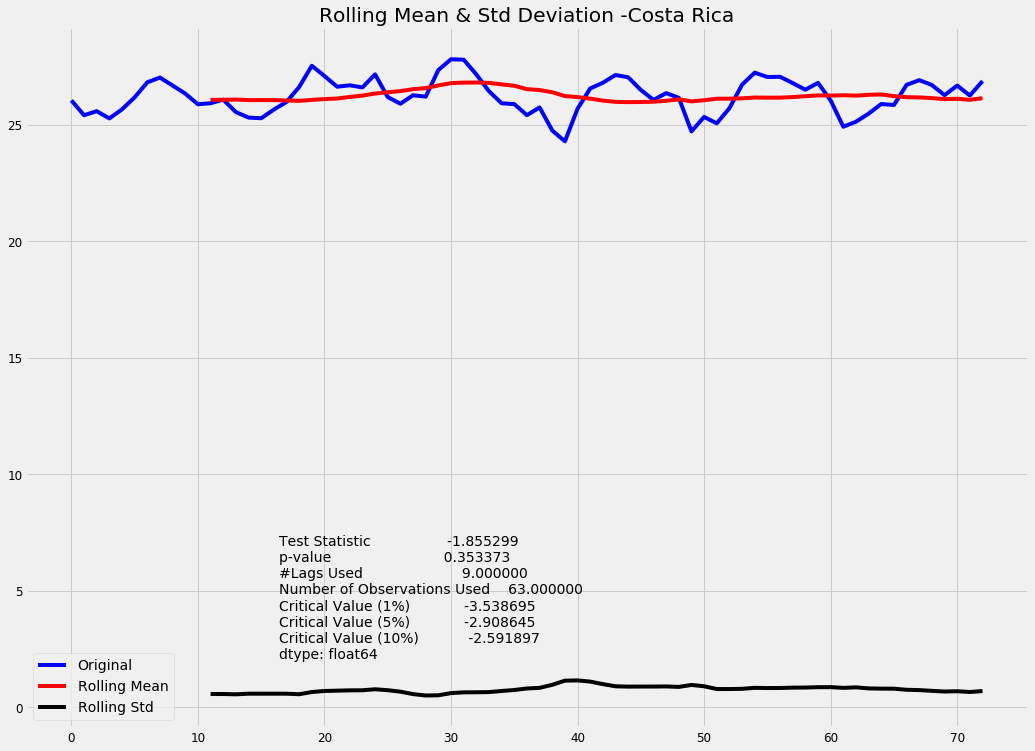

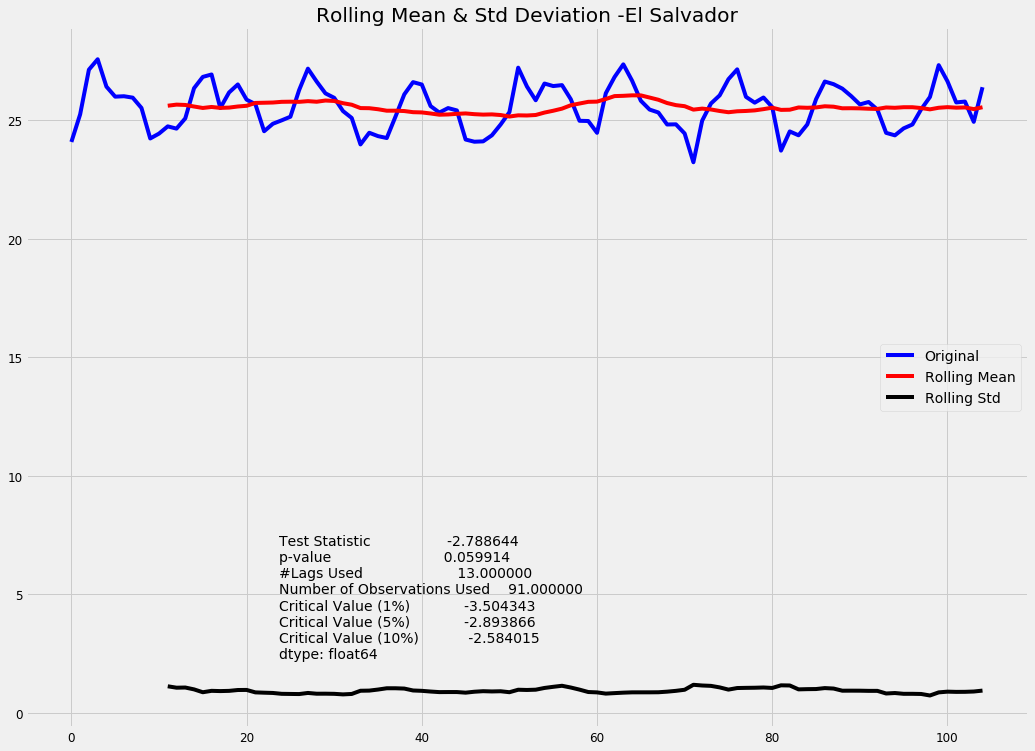

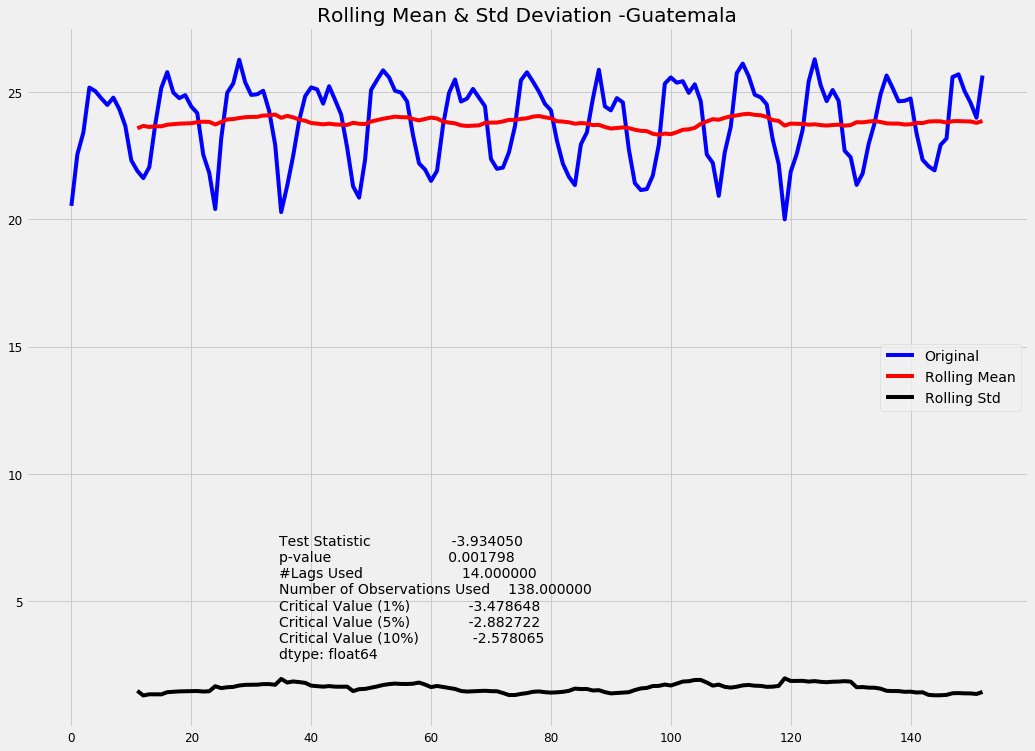

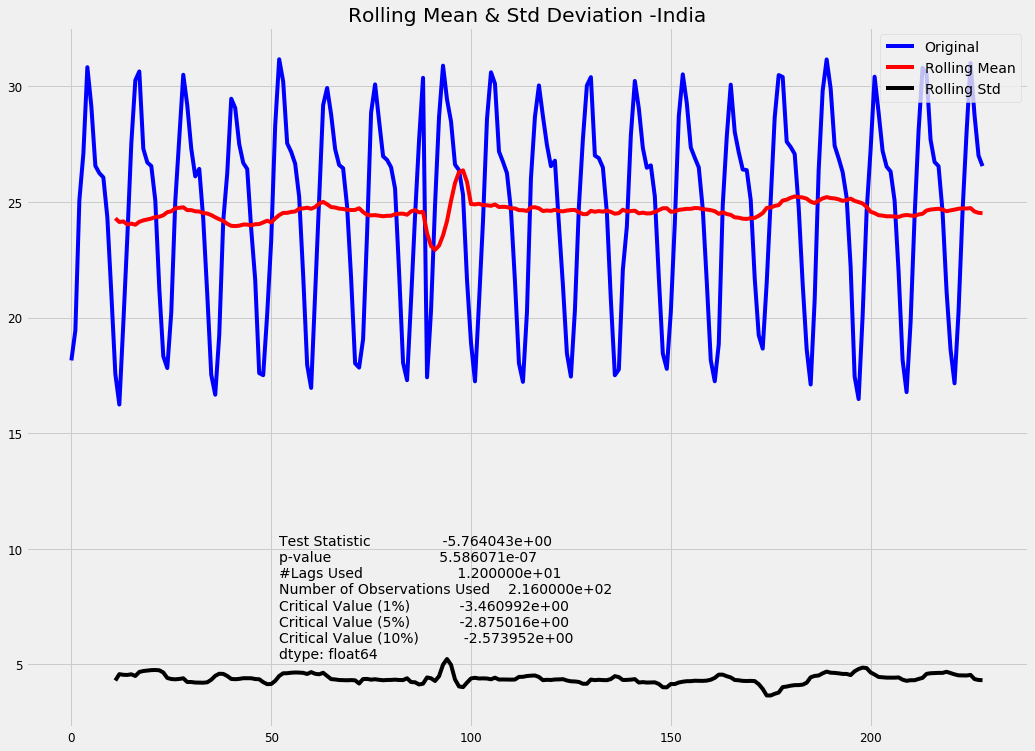

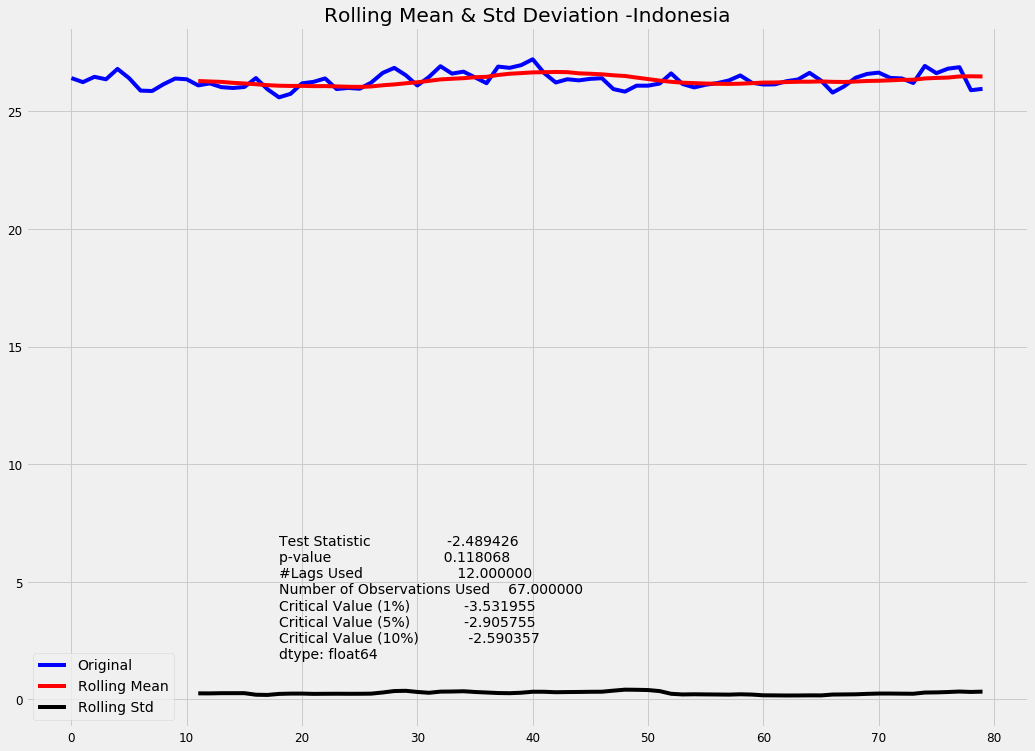

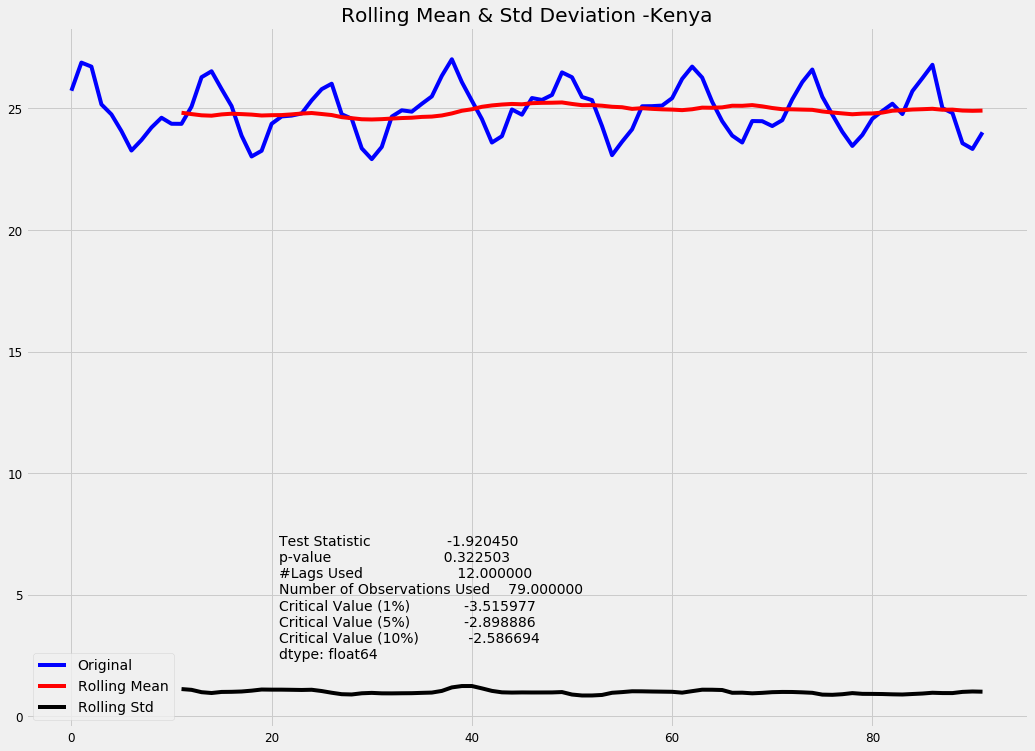

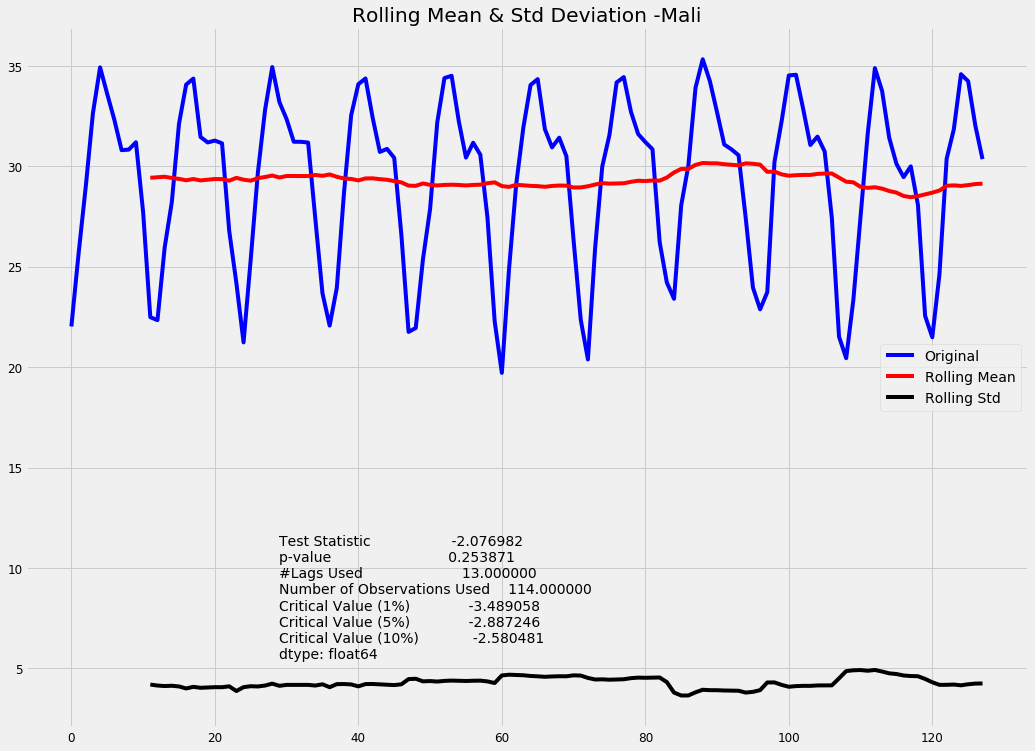

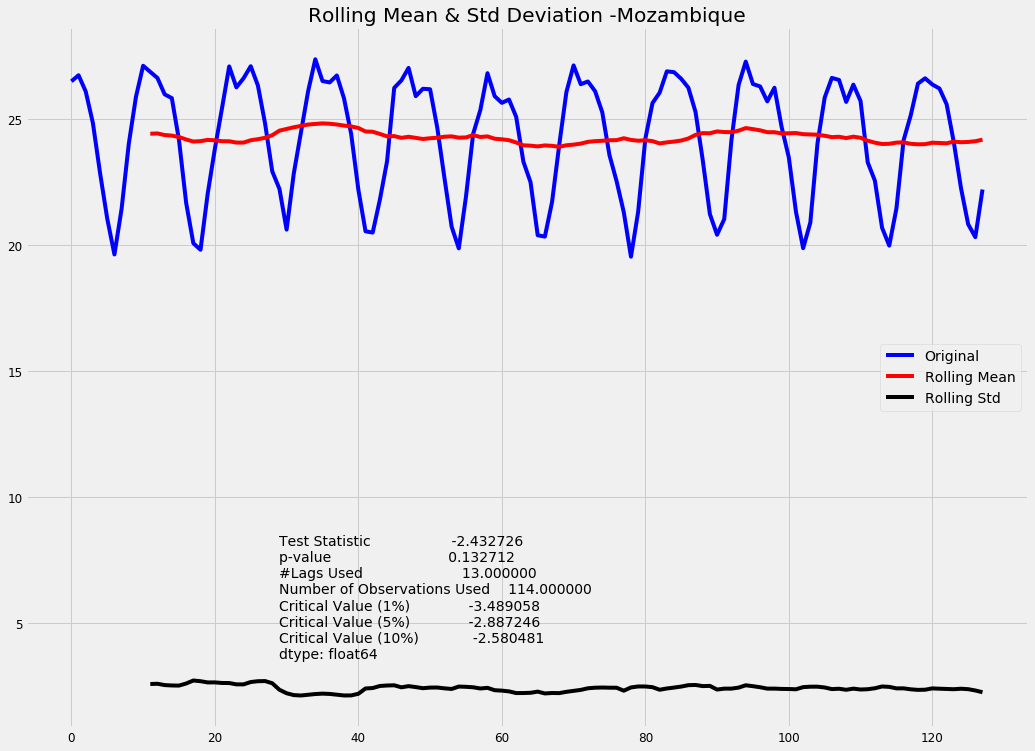

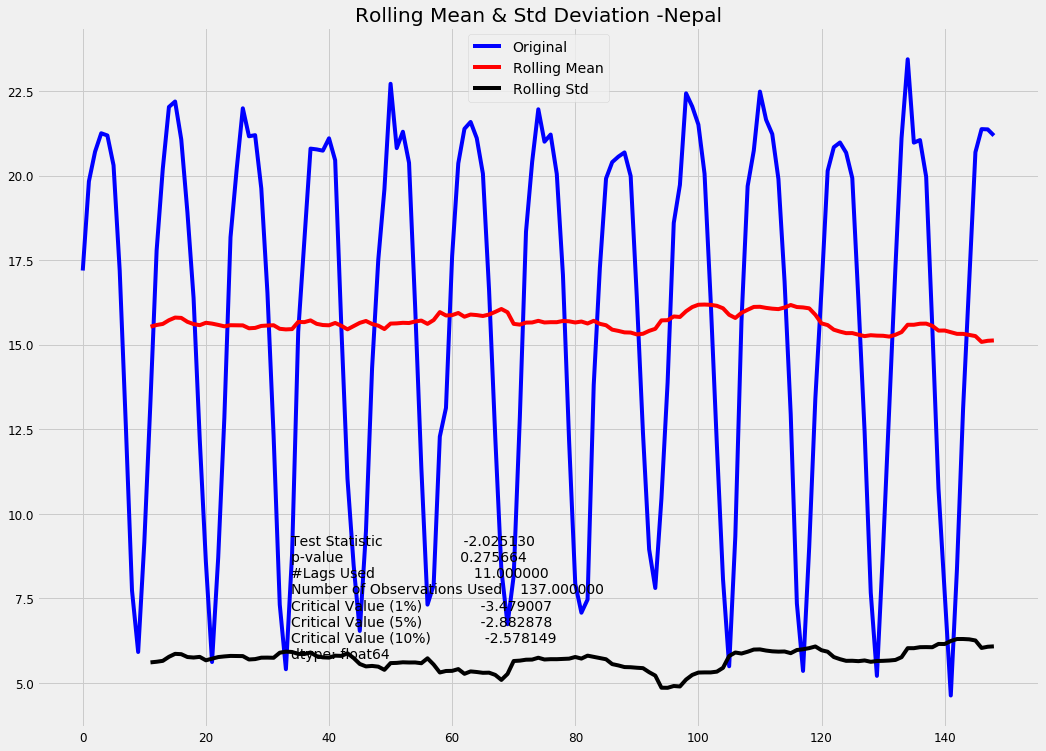

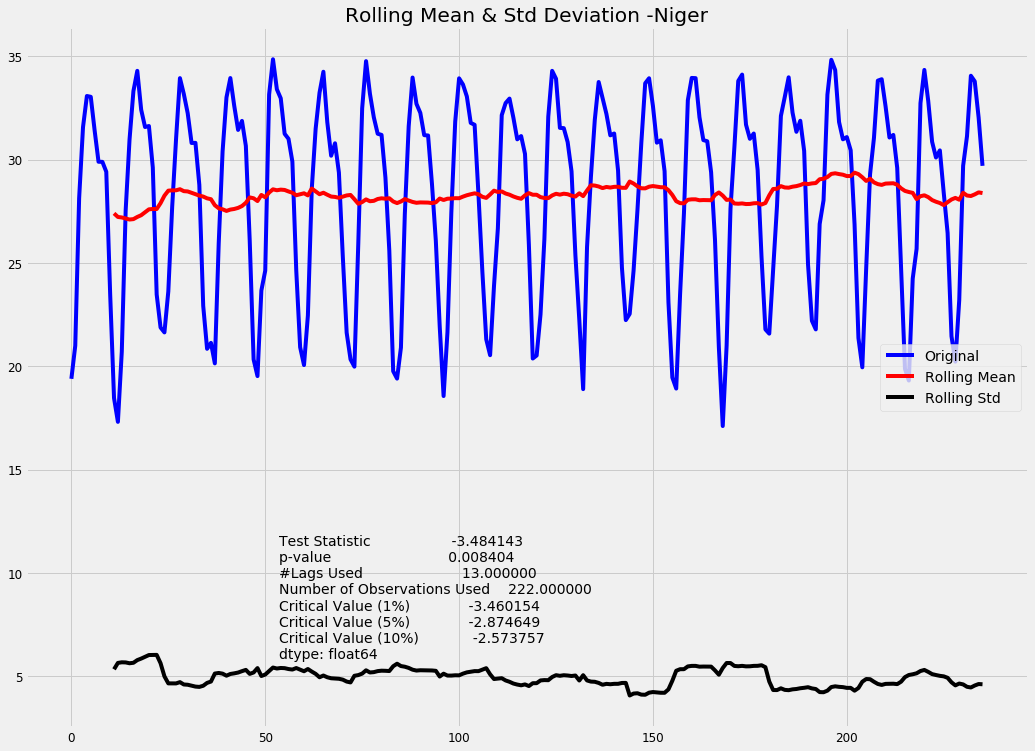

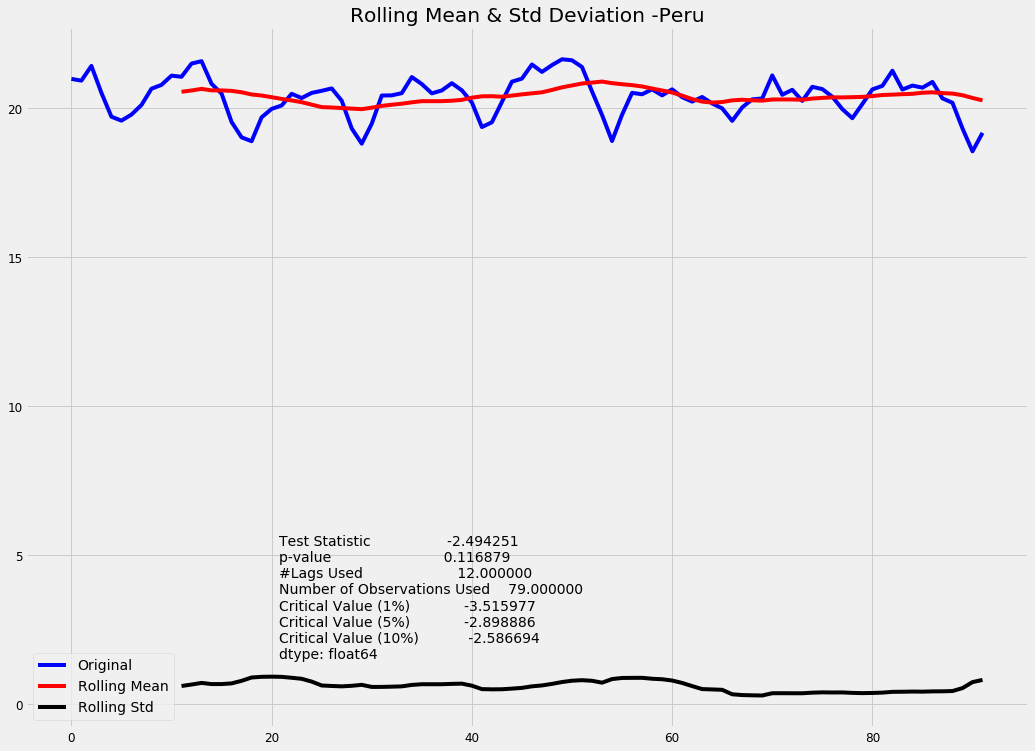

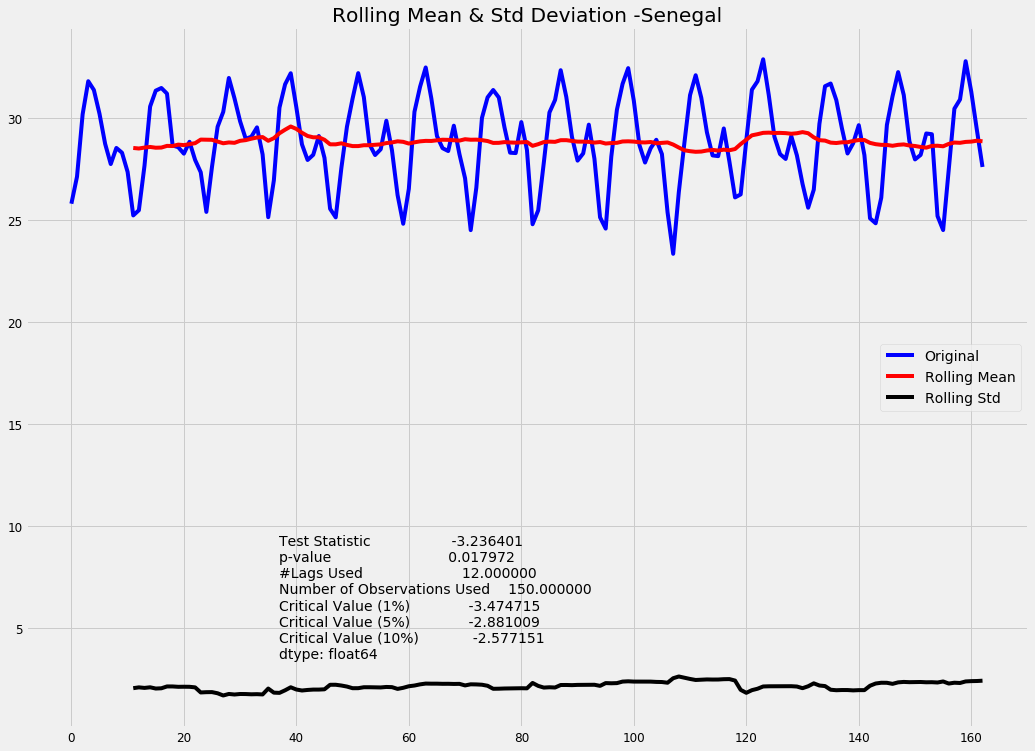

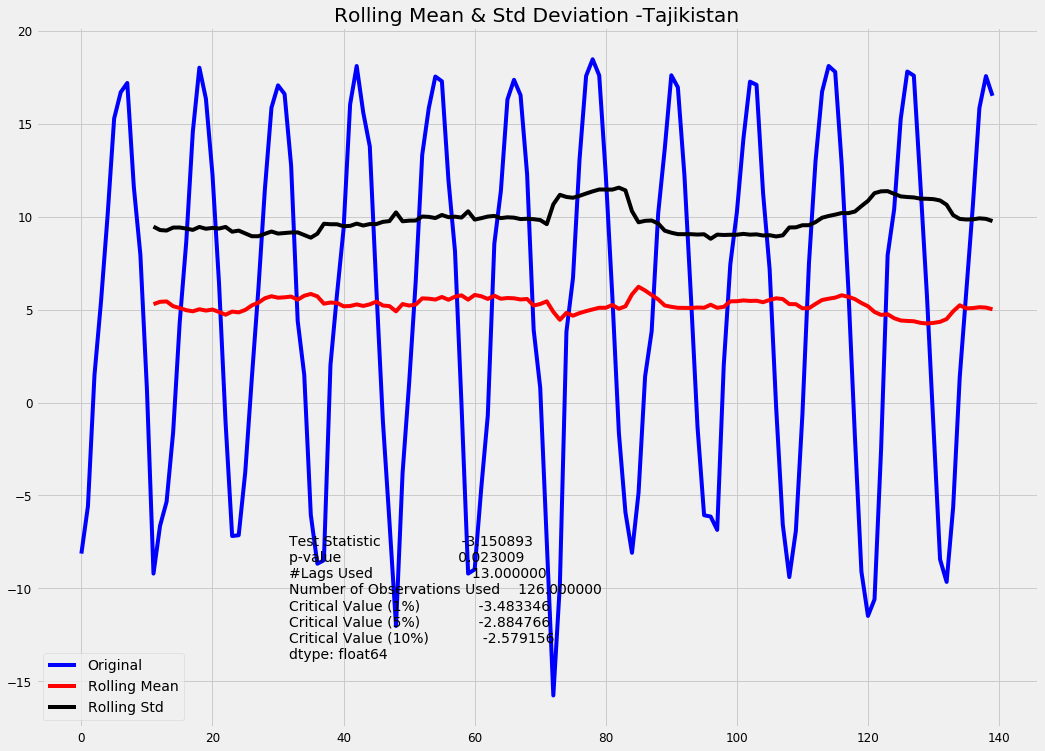

In [15]:
print('writing ADF test result for avg_temp...')
for i in range(len(idx.tolist())):
    df = pd.DataFrame()
    df = series1[(series1['country'] == idx.tolist()[i])]
    df = df.groupby('period')['avg_temp'].mean().reset_index()
    st_check(df, idx.tolist()[i], 'avg_temp', './plot-timeseries-ADtest-avgtemp/', text_file1, 'temp')

Check stationarity for food prices

writing ADF test result for food prices...


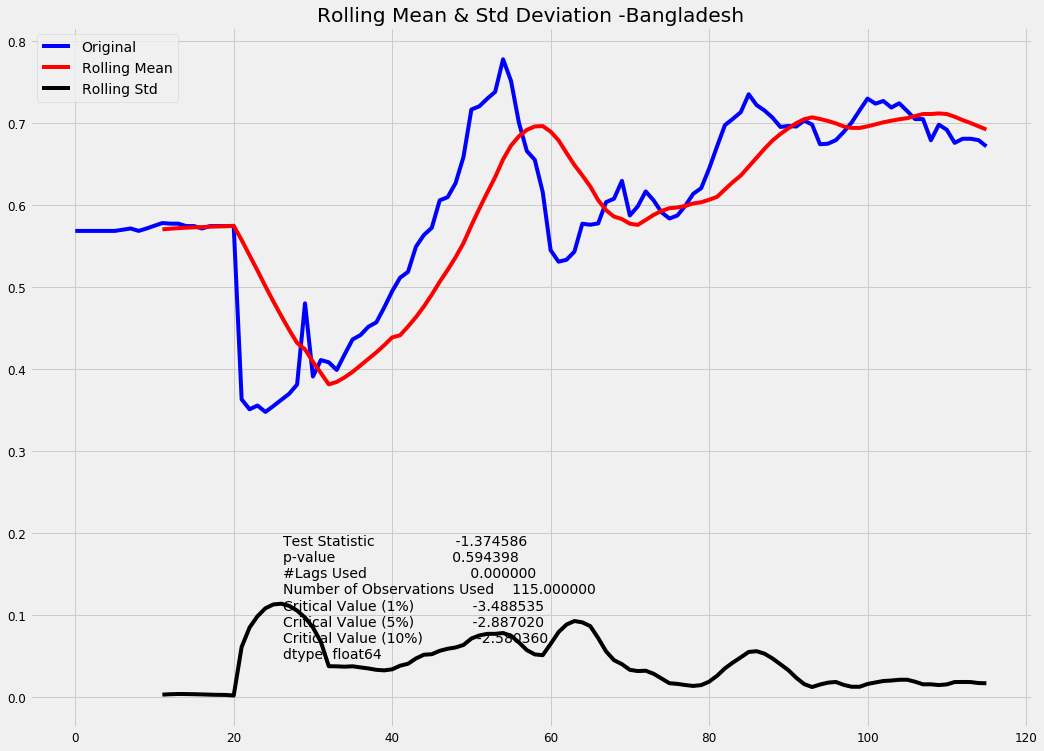

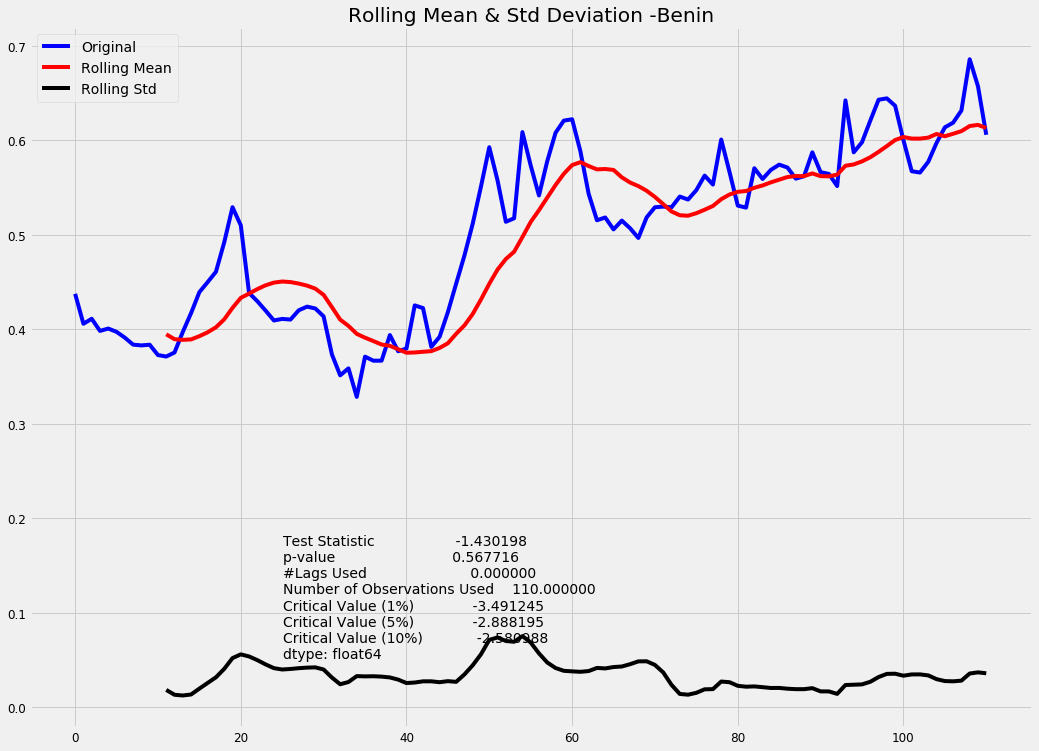

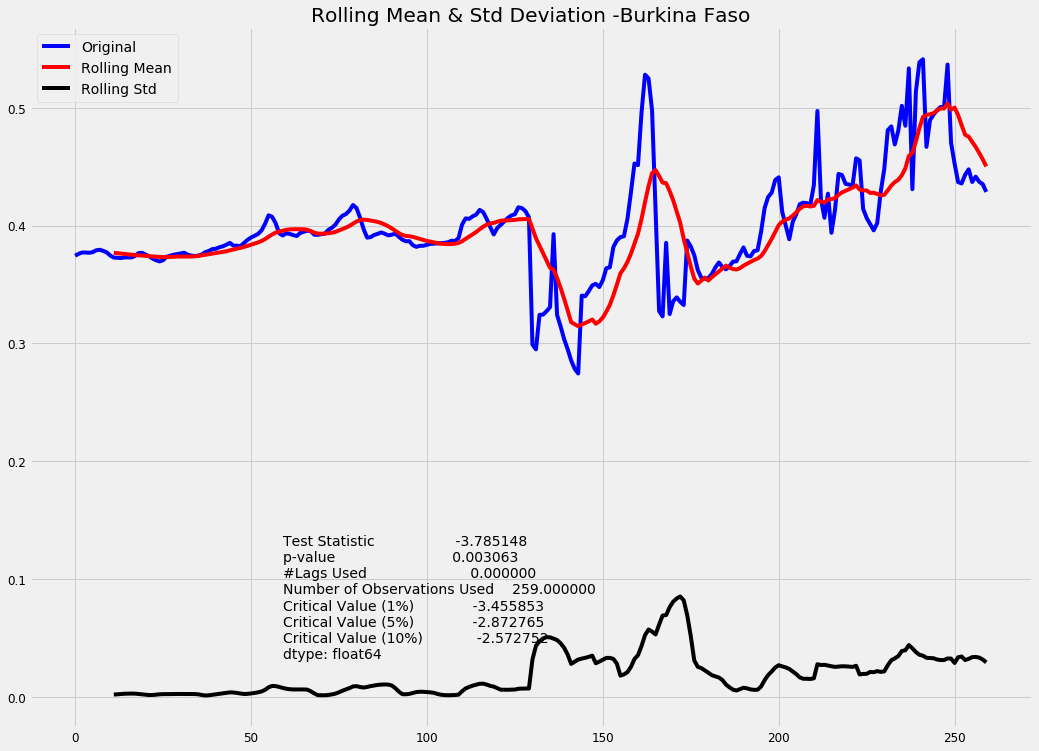

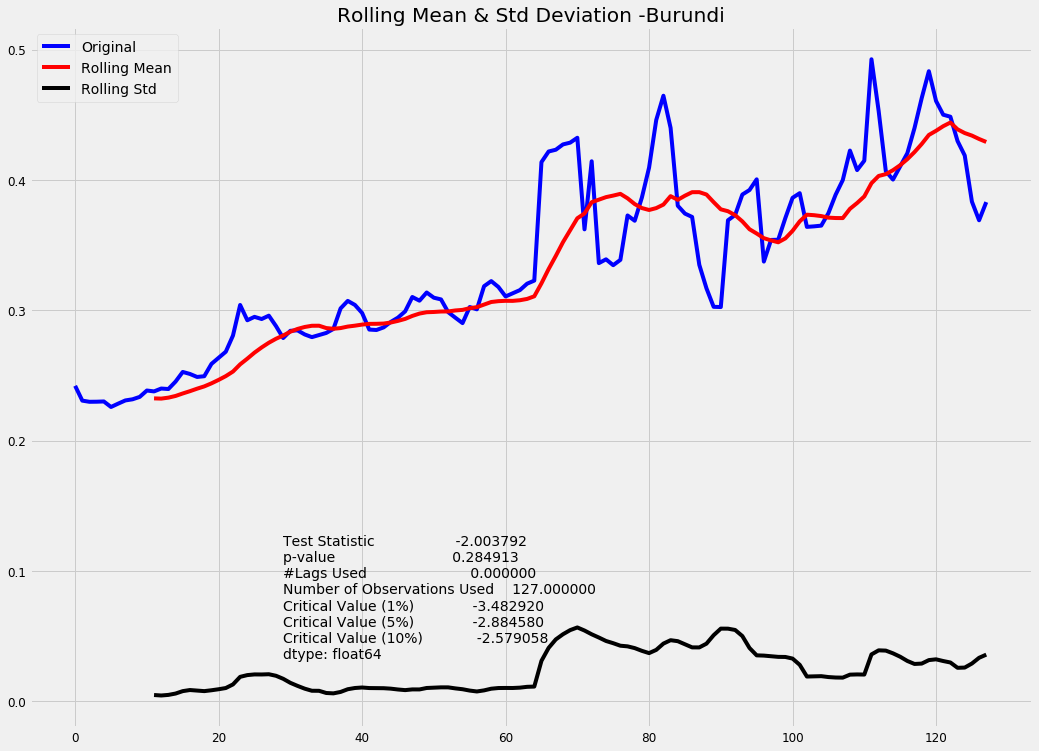

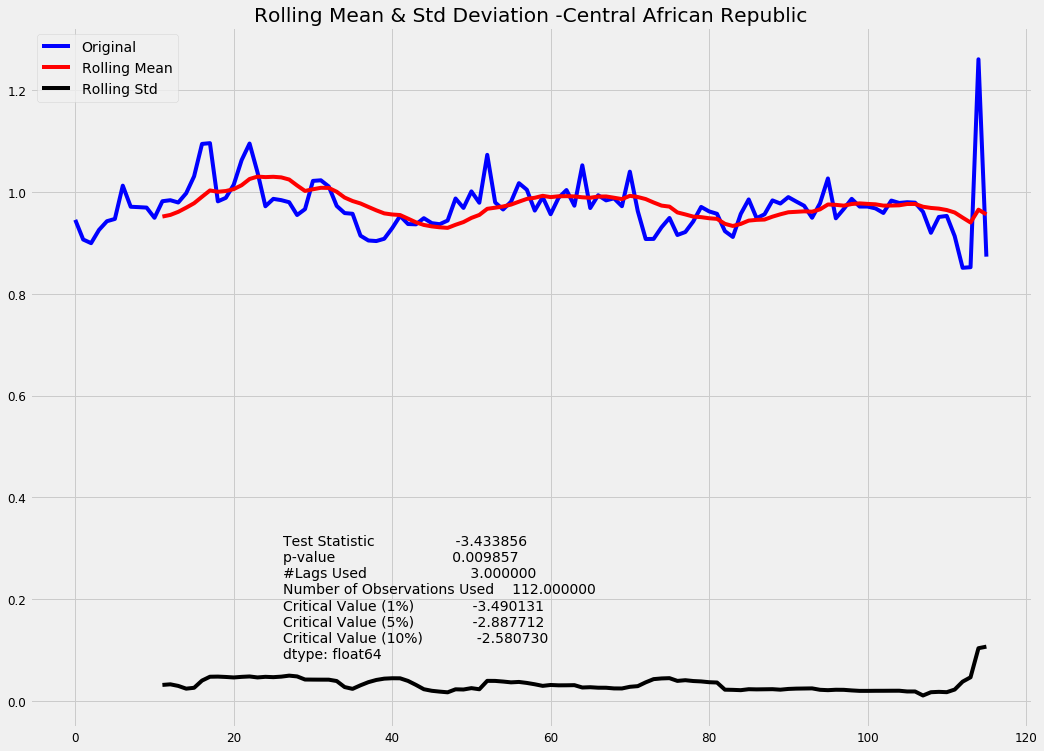

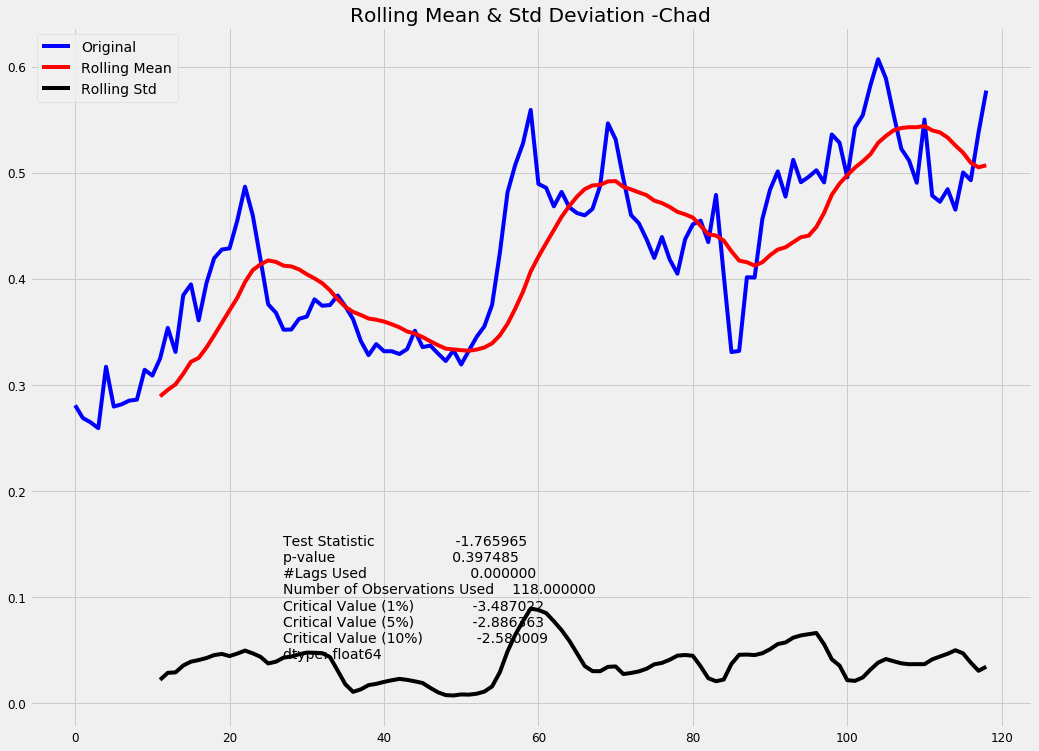

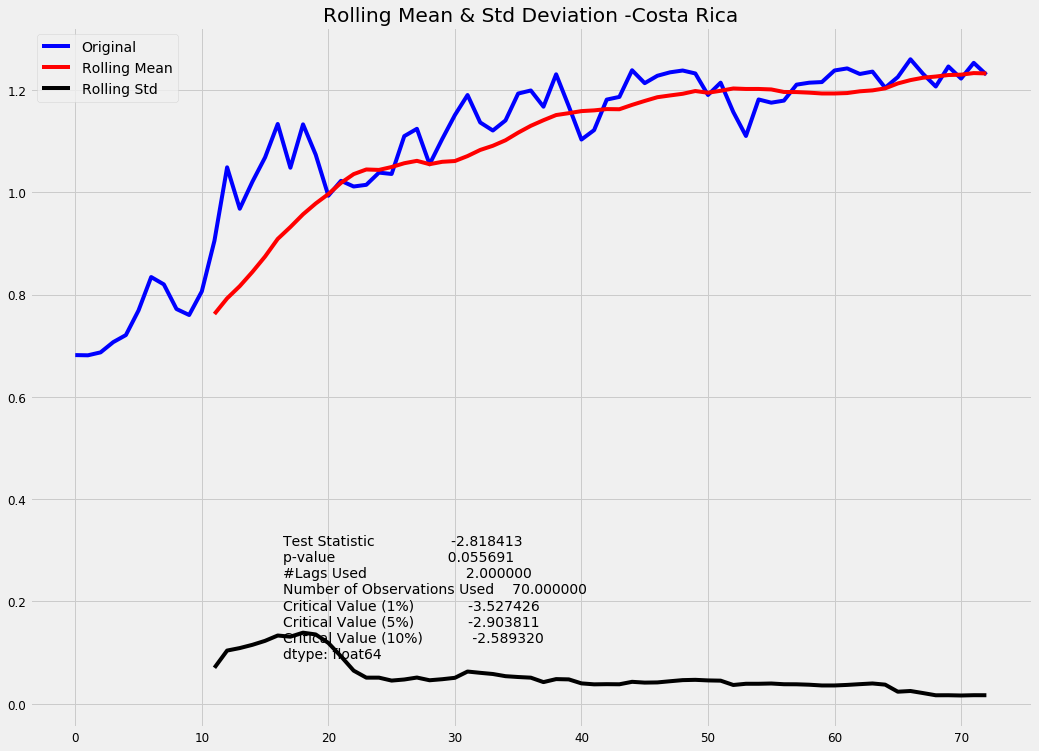

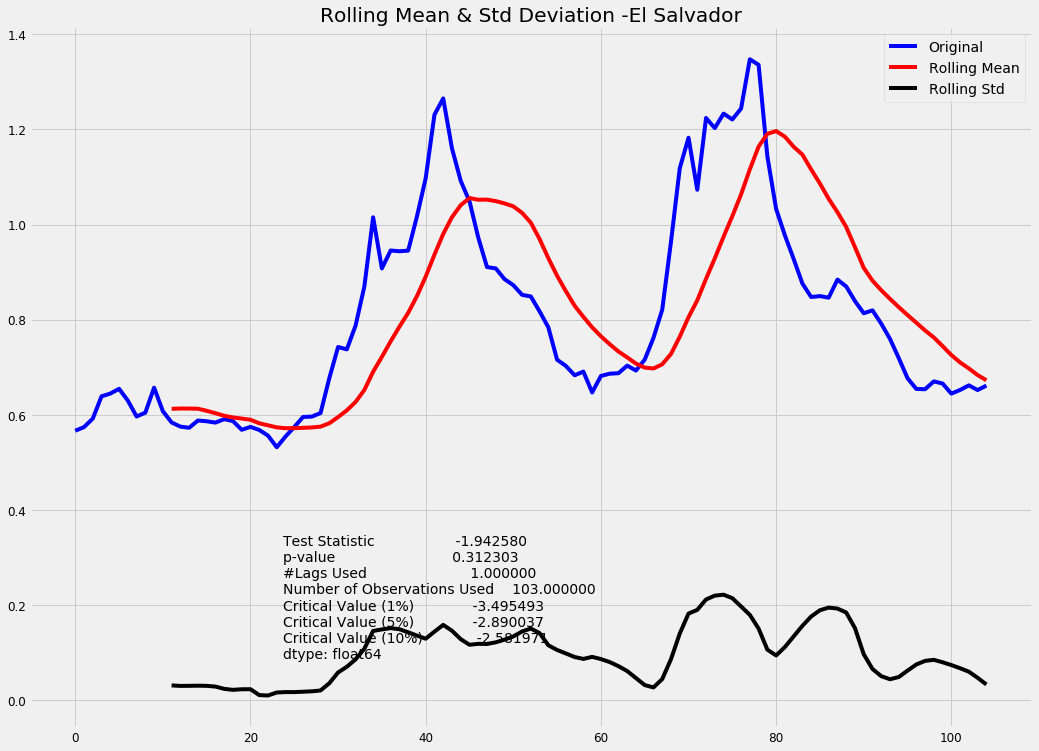

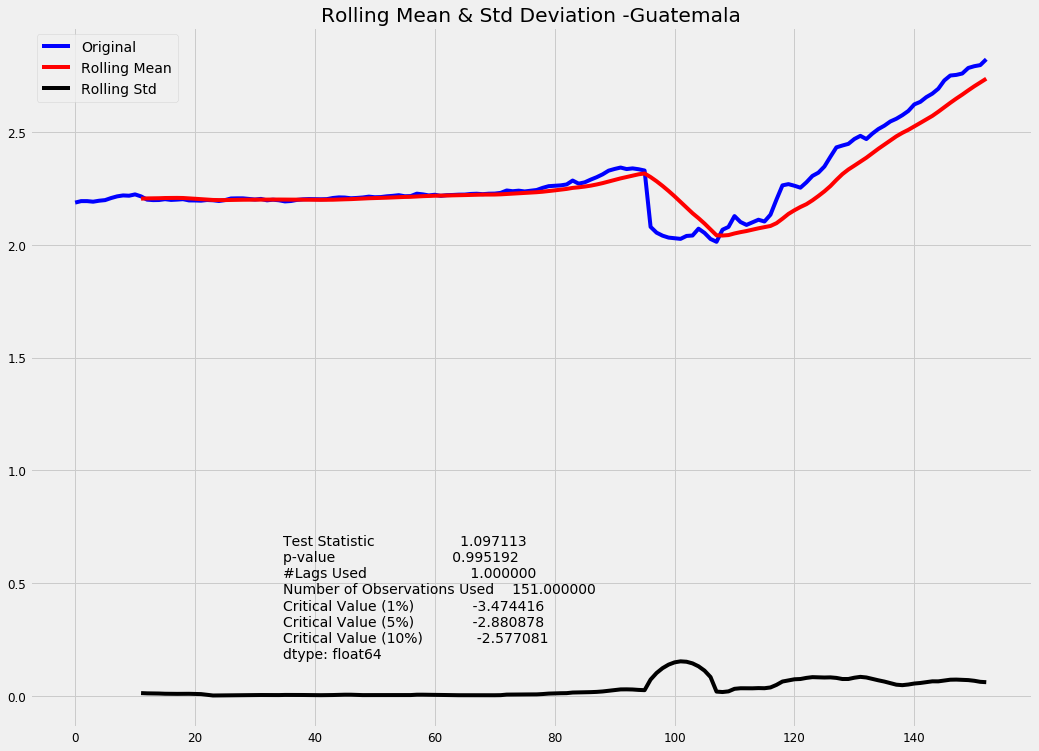

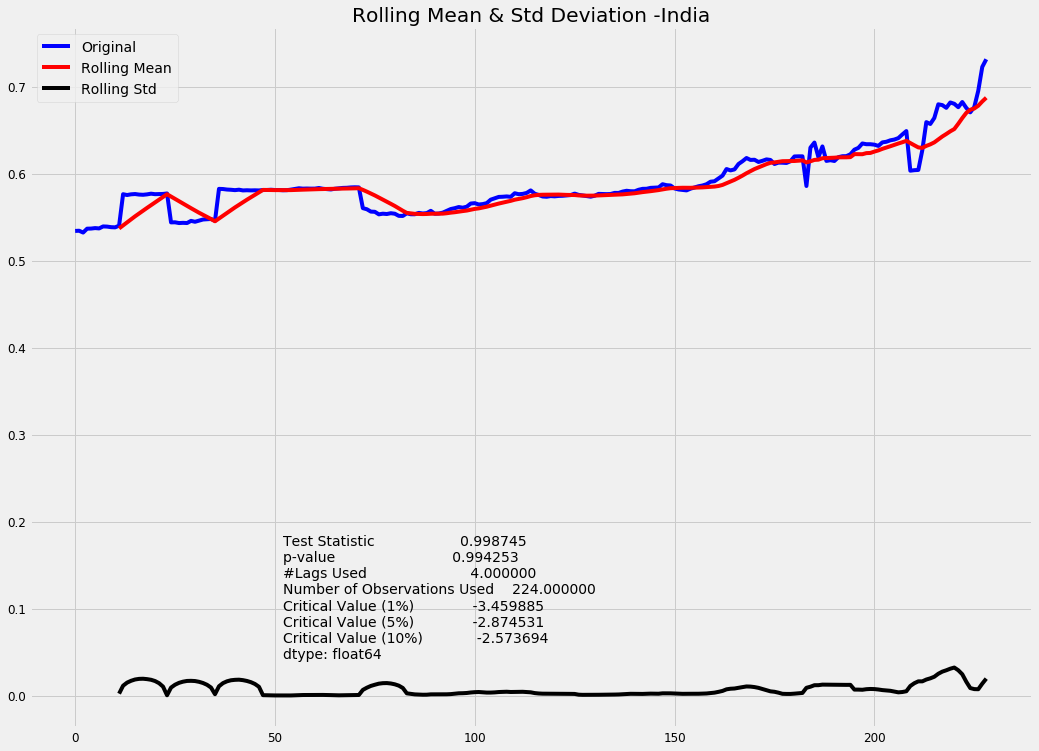

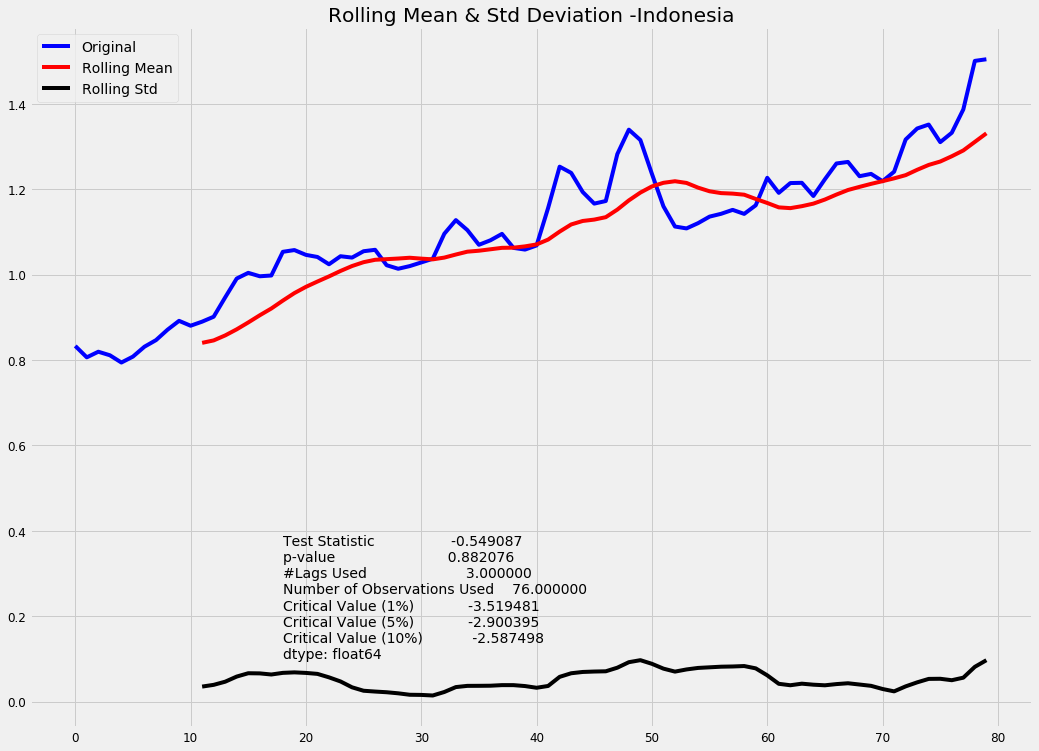

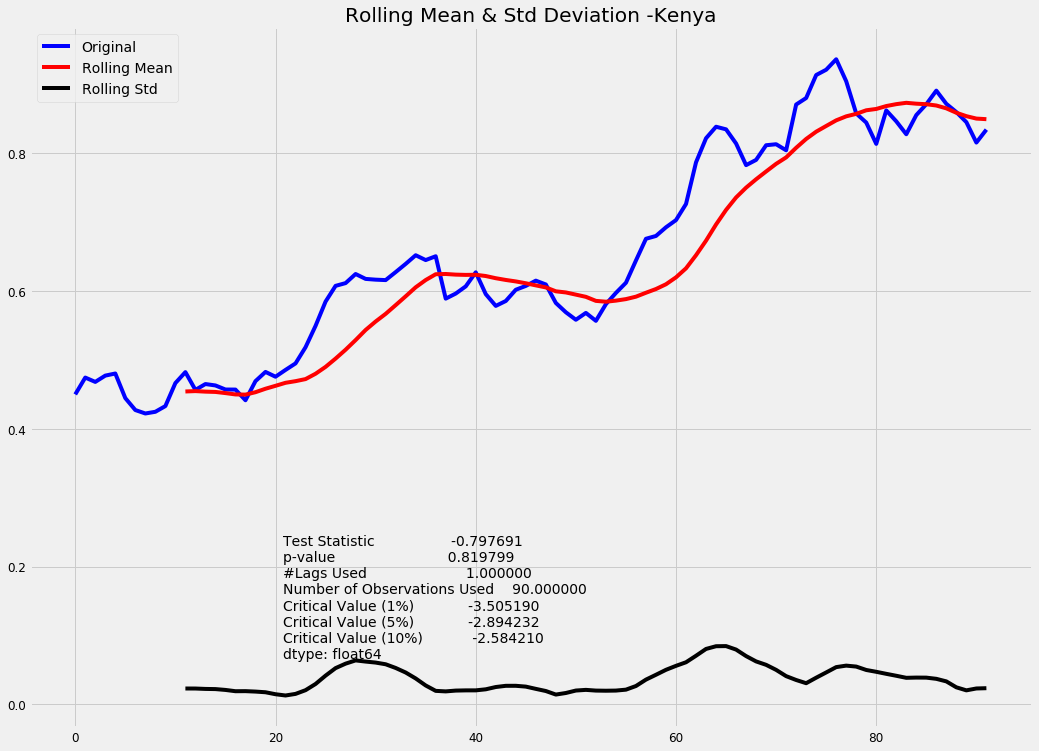

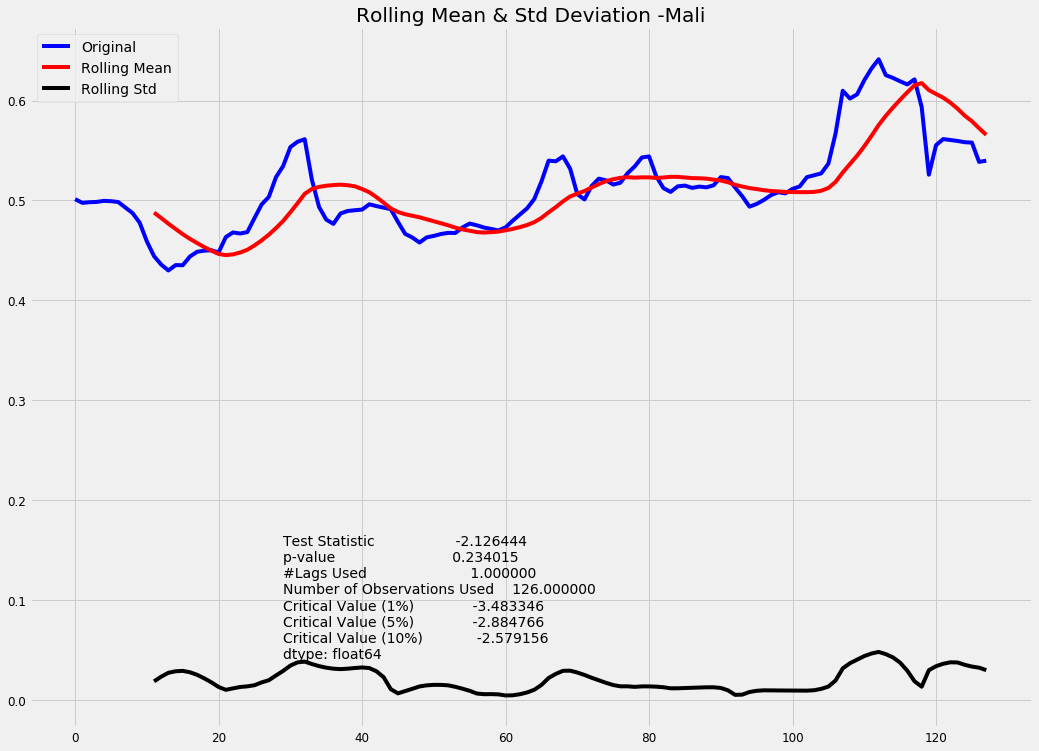

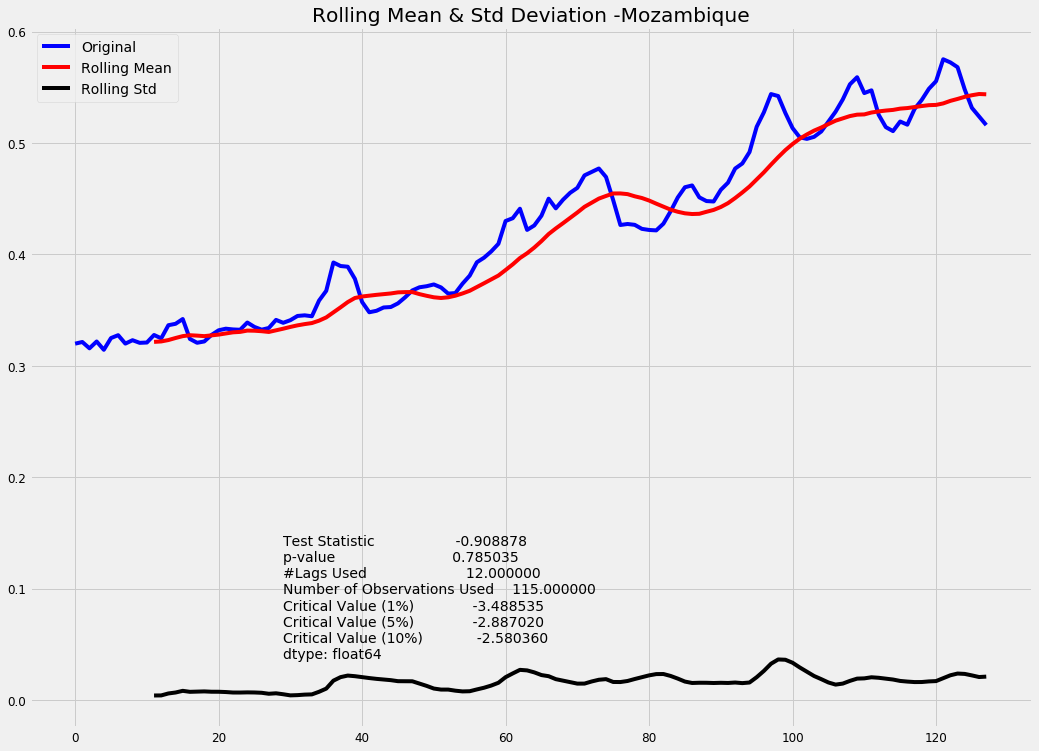

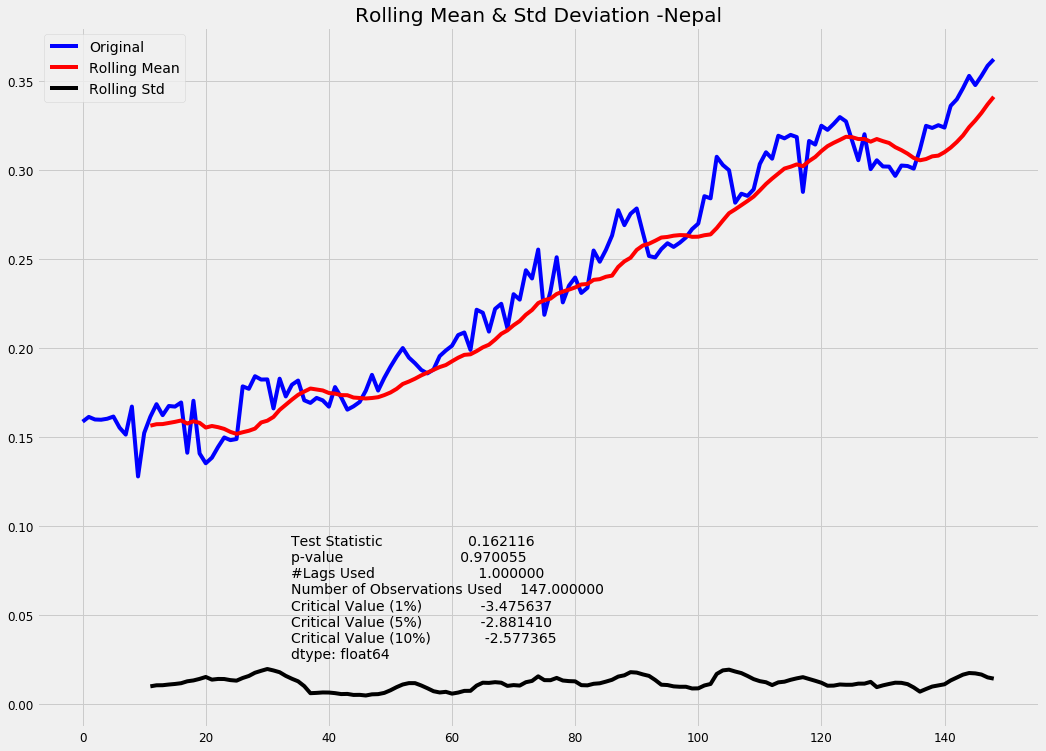

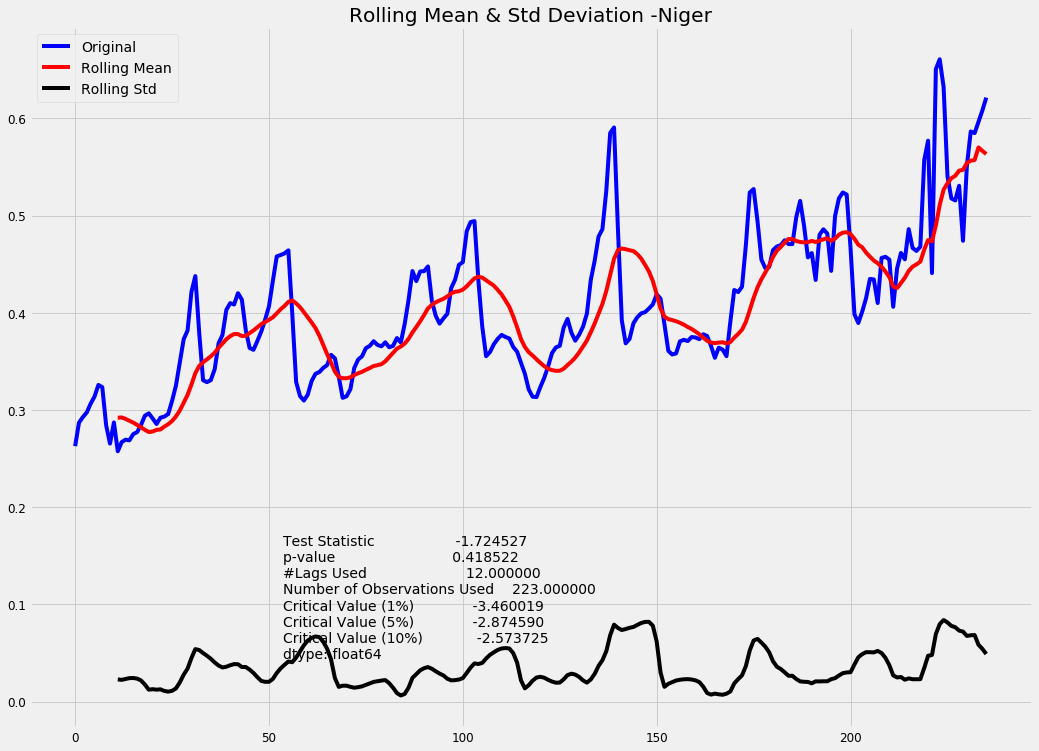

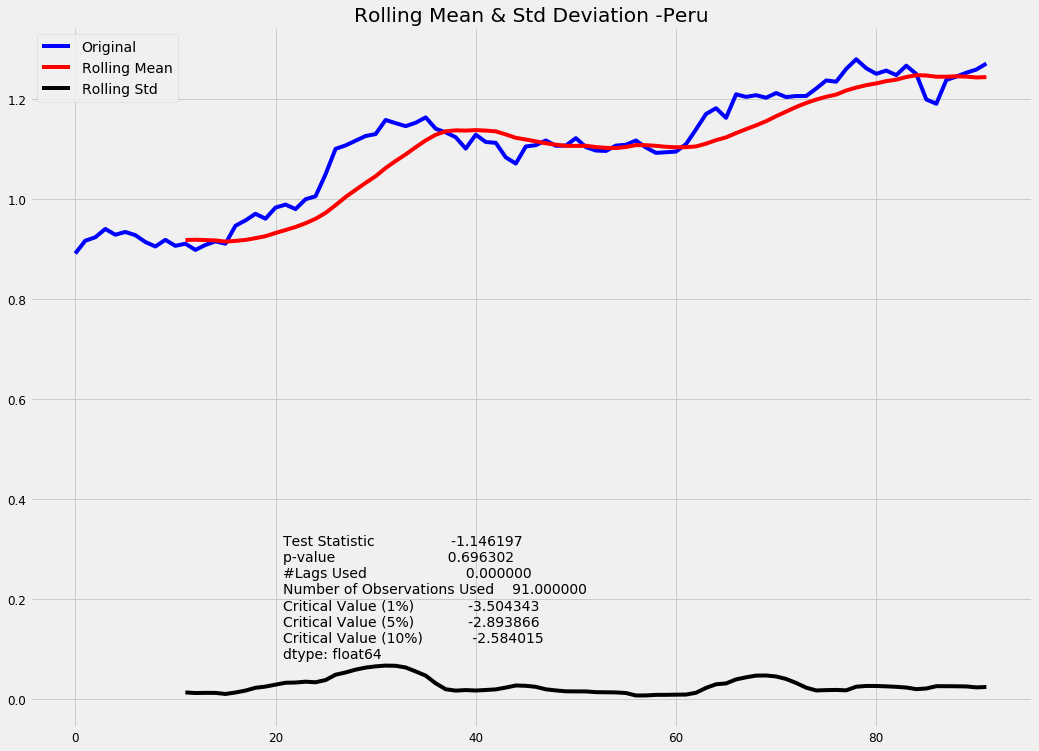

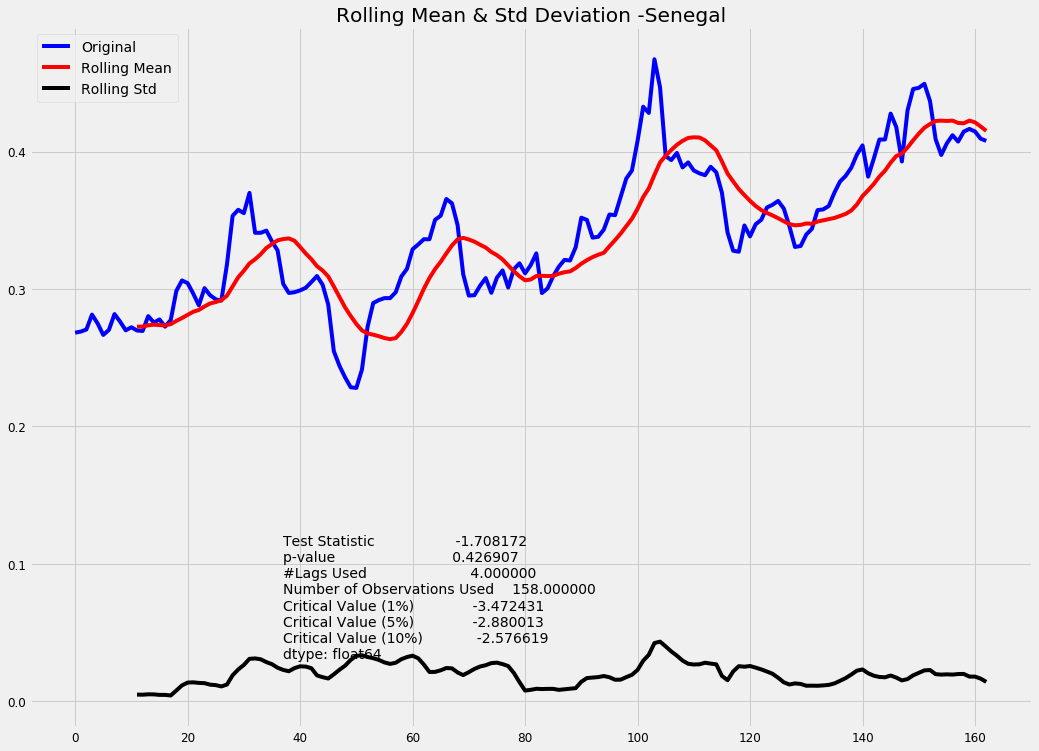

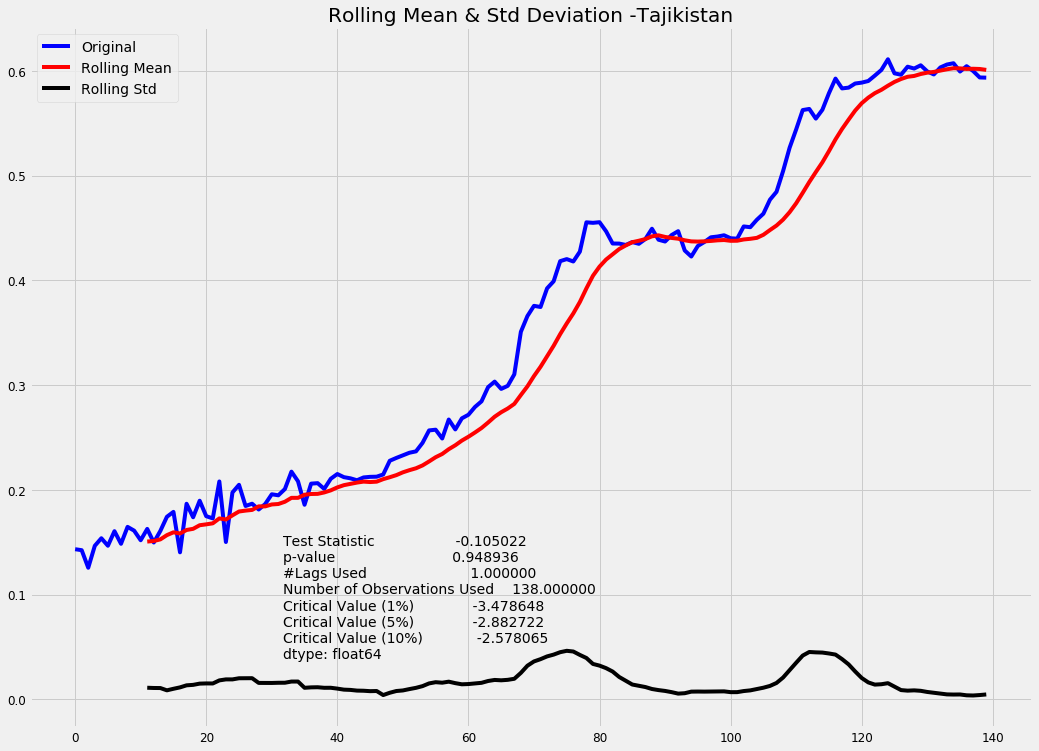

In [16]:
print('writing ADF test result for food prices...')
for i in range(len(idx.tolist())):
    df = pd.DataFrame()
    df = series1[(series1['country'] == idx.tolist()[i])]
    df = df.groupby('period')['price_in_USD'].mean().reset_index()
    st_check(df, idx.tolist()[i],'price_in_USD', './plot-timeseries-ADtest-foodprices/', text_file2, 'prices')